# How has Citi Bike ridership changed during the pandemic?

This notebook examines data [published by Citibike](https://ride.citibikenyc.com/system-data) on all trips taken using its rideshare program. 

This project seeks to quantify the increase in Citi Bike ridership during the pandemic and understand how geographic riding patterns may have changed during that increase. 

Questions:
- How much exactly has Citi Bike ridership grown?
- Are people still using Citi Bike to commute during rush hour? Has rush hour for Citi Bike shifted?
- How does Citi Bike ridership compare with MTA subway ridership?
- Has the ratio of casual vs. member riders shifted?
- What are the most common paths (docks riders begin and end trips at) taken by Citi Bike riders? How has that changed?

### Imports, reading in and cleaning the data

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from plotnine import *
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
months = [str(i).zfill(2) for i in range(1, 13)]

In [3]:
filenames18 = ['2018{}-citibike-tripdata.csv'.format(i) for i in months]
filenames19 = ['2019{}-citibike-tripdata.csv'.format(i) for i in months]
filenames20 = ['2020{}-citibike-tripdata.csv'.format(i) for i in months]
filenames21 = ['2021{}-citibike-tripdata.csv'.format(i) for i in months]

In [4]:
columns_to_read_new = [
    'started_at',
    'ended_at',
    'start_station_name',
    'start_lat',
    'start_lng',
    'end_station_name',
    'end_lat',
    'end_lng',
    'member_casual',
]

In [5]:
columns_to_read_old = [
    'starttime',
    'stoptime',
    'start station name',
    'start station latitude',
    'start station longitude',
    'end station name',
    'end station latitude',
    'end station longitude',
    'usertype',
]

In [6]:
#Citibike changed its column headers in February 2021. 
#For simplicity, manually changing the column headers on the January 2021 file here
jan21 = pd.read_csv('202101-citibike-tripdata.csv')
jan21.columns = jan21.columns.str.replace(' ', '_').str.replace('latitude', 'lat').str.replace('longitude', 'lng').str.replace('starttime', 'started_at').str.replace('stoptime', 'ended_at').str.replace('usertype', 'member_casual').str.replace('station_lat', 'lat').str.replace('station_lng', 'lng')
jan21.member_casual = jan21.member_casual.apply(lambda x:{'Subscriber': 'member','Customer': 'casual'}[x] if x == 'Subscriber' or  x == 'Customer' else x)
jan21.to_csv('202101-citibike-tripdata.csv')

In [7]:
def read_files(filenames, old_headers):
    dfs = []
    for file in tqdm(filenames):
        if old_headers == True:
            df = pd.read_csv(file, usecols=columns_to_read_old, parse_dates=['starttime', 'stoptime'])
            df.columns = df.columns.str.replace(' ', '_').str.replace('latitude', 'lat').str.replace('longitude', 'lng').str.replace('starttime', 'started_at').str.replace('stoptime', 'ended_at').str.replace('usertype', 'member_casual').str.replace('station_lat', 'lat').str.replace('station_lng', 'lng')
            df.member_casual = df.member_casual.apply(lambda x:{'Subscriber': 'member','Customer': 'casual'}[x] if x == 'Subscriber' or  x == 'Customer' else x)
        else:
            df = pd.read_csv(file, usecols=columns_to_read_new, parse_dates=['started_at', 'ended_at'])
            df = df[df.ended_at > df.started_at]
        df = df[df.ended_at > df.started_at] #Removing data anomolies where ride ends before it begins
        dfs.append(df)
    return pd.concat(dfs)

In [8]:
df21 = read_files(filenames21, False)

100%|███████████████████████████████████████████| 12/12 [01:15<00:00,  6.32s/it]


In [9]:
df20 = read_files(filenames20, True)

100%|███████████████████████████████████████████| 12/12 [00:55<00:00,  4.60s/it]


In [10]:
df19 = read_files(filenames19, True)

100%|███████████████████████████████████████████| 12/12 [00:59<00:00,  4.99s/it]


In [11]:
df18 = read_files(filenames18, True)

100%|███████████████████████████████████████████| 12/12 [00:53<00:00,  4.49s/it]


## How much has Citi Bike ridership grown?

In [19]:
#Percent growth in total rides over the last four years
(df21.shape[0] - df18.shape[0]) / df18.shape[0] * 100

57.53976487461292

In [20]:
#Increase in number of stations
print(df18.start_station_name.nunique())
print(df21.start_station_name.nunique())

821
1568


In [21]:
print(df18.end_station_name.nunique())
print(df21.end_station_name.nunique())

853
1642


## Are people still using Citi Bike to commute during rush hour? Has rush hour for Citi Bike shifted?

The morning rush has shrunk during the pandemic, but the evening rush is still alive. 

In [23]:
hours21 = df21.started_at.dt.hour.value_counts().sort_values().reset_index(name='num_rides').sort_values('index')
hours20 = df20.started_at.dt.hour.value_counts().sort_values().reset_index(name='num_rides').sort_values('index')
hours19 = df19.started_at.dt.hour.value_counts().sort_values().reset_index(name='num_rides').sort_values('index')
hours18 = df18.started_at.dt.hour.value_counts().sort_values().reset_index(name='num_rides').sort_values('index')

In [24]:
hours21['pct_rides'] = hours21.num_rides / hours21.num_rides.sum() * 100
hours20['pct_rides'] = hours20.num_rides / hours20.num_rides.sum() * 100
hours19['pct_rides'] = hours19.num_rides / hours19.num_rides.sum() * 100
hours18['pct_rides'] = hours18.num_rides / hours18.num_rides.sum() * 100

In [25]:
hours21['year'] = 2021
hours20['year'] = 2020
hours19['year'] = 2019
hours18['year'] = 2018
hours_all = pd.concat([hours21, hours20, hours19, hours18])

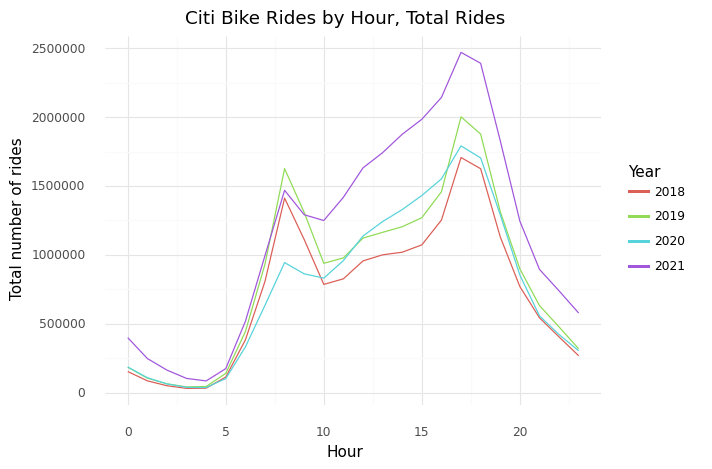

<ggplot: (326530274)>

In [26]:
display(
    ggplot(hours_all)
    + geom_line(aes(x='index', y='num_rides', group='year', color='factor(year)'))
    + labs(title='Citi Bike Rides by Hour, Total Rides', 
           x='Hour', 
           y='Total number of rides',
           color='Year')
    + theme_minimal()
)

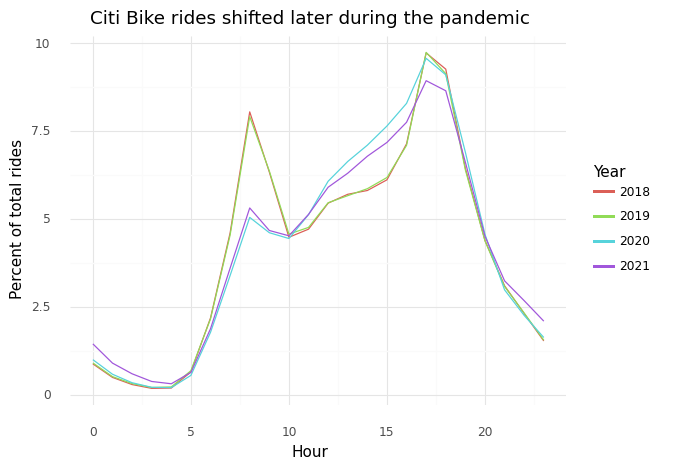

<ggplot: (345713677)>

In [35]:
display(
    ggplot(hours_all)
    + geom_line(aes(x='index', y='pct_rides', group='year', color='factor(year)'))
    + labs(title='Citi Bike rides shifted later during the pandemic', 
           x='Hour', 
           y='Percent of total rides',
           color='Year')
    + theme_minimal()
)

In [460]:
hours_all.groupby(['year', 'index']).pct_rides.max()

year  index
2018  0        0.874892
      1        0.489237
      2        0.285754
      3        0.177384
      4        0.186701
      5        0.645241
      6        2.181591
      7        4.603091
      8        8.050186
      9        6.336081
      10       4.479427
      11       4.710030
      12       5.451023
      13       5.703155
      14       5.810755
      15       6.114658
      16       7.139126
      17       9.728015
      18       9.265914
      19       6.446627
      20       4.389076
      21       3.098470
      22       2.306583
      23       1.526982
2019  0        0.901794
      1        0.512040
      2        0.312908
      3        0.202217
      4        0.218459
      5        0.680659
      6        2.155768
      7        4.541615
      8        7.915473
      9        6.365304
      10       4.569457
      11       4.760113
      12       5.462074
      13       5.663703
      14       5.862046
      15       6.180550
      16       7.096241
    

## How does Citi Bike ridership compare with MTA ridership?

MTA data sourced from [its website](https://new.mta.info/coronavirus/ridership).

#### Plotting MTA Subway ridership over pandemic months

In [36]:
mta = pd.read_csv('mta-ridership.csv')

In [37]:
mta.Date = pd.to_datetime(mta.Date)

In [38]:
mta_months = mta.resample('M', on='Date')['Subways: Total Estimated Ridership'].sum().reset_index(name='ridership')

In [39]:
mta_months.rename(columns={'Date': 'month'}, inplace=True)

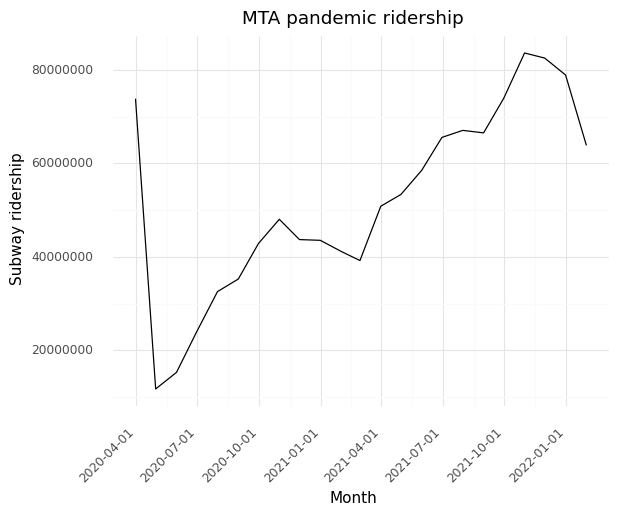

<ggplot: (339196067)>

In [40]:
display(
    ggplot(mta_months, aes('month', 'ridership'))
    + geom_line()
    + labs(title='MTA pandemic ridership', x='Month', y='Subway ridership')
    + theme_minimal()
    + theme(axis_text_x  = element_text(angle = 45, hjust = 1))
)#need to rotate labels

#### Plotting Citi Bike ridership over pandemic months

In [41]:
pandemic = pd.concat([df20, df21])
pandemic_months = pandemic.resample('M', on='started_at').size().reset_index(name='num_rides')

In [42]:
pandemic_months.rename(columns={'started_at': 'month'}, inplace=True)

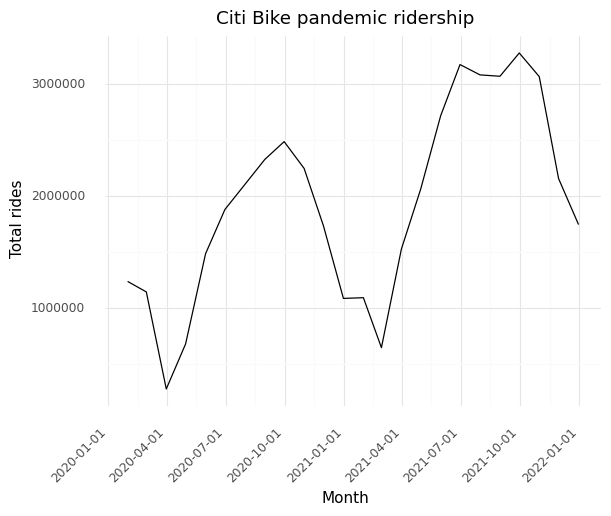

<ggplot: (339231066)>

In [43]:
display(
    ggplot(aes('month', 'num_rides'), data=pandemic_months) 
    + geom_line()
    + labs(title='Citi Bike pandemic ridership', y='Total rides', x='Month')
    + theme_minimal()
    + theme(axis_text_x  = element_text(angle = 45, hjust = 1))
)

#### Mapping percent change to display both on the same chart

In [44]:
mta_months['pct_change'] = mta_months.select_dtypes(include=['number']).pct_change() * 100

In [45]:
pandemic_months['pct_change'] = pandemic_months.select_dtypes(include=['number']).pct_change() * 100

In [46]:
#Standardizing timeframe based on the limits of the datasets (April 2020 to December 2021)
mta_months = mta_months[1:-1]

In [47]:
pandemic_months = pandemic_months[3:]

In [48]:
pandemic_months['transit_type'] = 'Citi Bike'
mta_months['transit_type'] = 'Subway ridership'

In [49]:
mta_bike_combined = pd.concat([mta_months, pandemic_months])

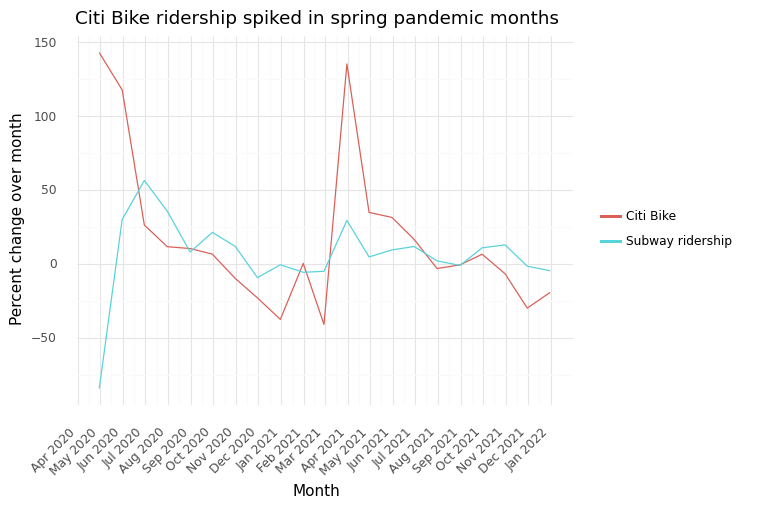

<ggplot: (342857458)>

In [63]:
def custom_format(breaks):
    fmt = '%b %Y'
    res = []
    for x in breaks:
        res.append(x.strftime(fmt))
    return res

display(
    ggplot(mta_bike_combined) 
    + geom_line(aes(x='month', y='pct_change', group= 'transit_type', color='transit_type'))
    + theme_minimal()
    + theme(axis_text_x  = element_text(angle = 45, hjust = 1))
    + labs(title='Citi Bike ridership spiked in spring pandemic months',
           x='Month', y='Percent change over month', color='')
    + scale_x_datetime(breaks='1 month', labels=custom_format)
)

#### Mapping percent below pre-pandemic baseline

In [51]:
mta['Subways: % of Comparable Pre-Pandemic Day'] = mta['Subways: % of Comparable Pre-Pandemic Day'].str[:-1].astype(float)

In [52]:
mta_months_baseline = mta.resample('M', on='Date')['Subways: % of Comparable Pre-Pandemic Day'].median().reset_index(name='pct_from_baseline')

In [53]:
#Calculate pandemic baseline percentages
baselines = df19.resample('M', on='started_at').size().reset_index(name='ride_totals')

In [54]:
baselines = baselines.rename(columns={'started_at':'month'})

In [55]:
baselines['month_general'] = baselines.month.dt.month
pandemic_months['month_general'] = pandemic_months.month.dt.month

In [56]:
calculator = pandemic_months.merge(baselines, on='month_general')

In [57]:
calculator['pct_from_baseline'] = calculator.num_rides / calculator.ride_totals * 100

In [58]:
mta_months_baseline = mta_months_baseline.rename(columns={'Date':'month'})

In [59]:
mta_months_baseline['transit_type'] = 'Subway'

In [60]:
mta_months_baseline

,month,pct_from_baseline,transit_type
0,2020-03-31,40.50,Subway
1,2020-04-30,8.25,Subway
2,2020-05-31,10.60,Subway
3,2020-06-30,16.65,Subway
4,2020-07-31,23.00,Subway
5,2020-08-31,26.60,Subway
6,2020-09-30,28.75,Subway
7,2020-10-31,30.50,Subway
8,2020-11-30,31.05,Subway
9,2020-12-31,30.20,Subway


In [533]:
calculator = calculator.rename(columns={'month_x':'month'})

In [534]:
baseline_chart = pd.concat([mta_months_baseline, calculator])[['month', 'pct_from_baseline','transit_type']]

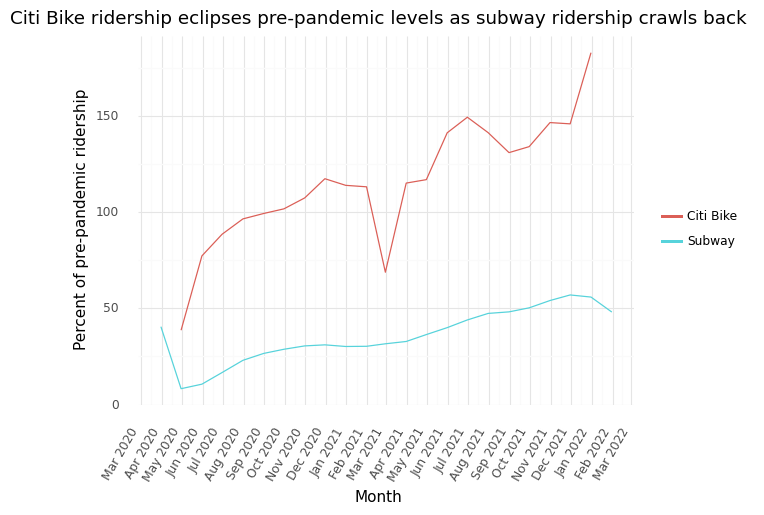

<ggplot: (344682349)>

In [537]:
display(
    ggplot(baseline_chart) 
    + geom_line(aes(x='month', y='pct_from_baseline', group= 'transit_type', color='transit_type'))
    + theme_minimal()
    + theme(axis_text_x  = element_text(angle = 60, hjust = 1))
    + labs(title='Citi Bike ridership eclipses pre-pandemic levels as subway ridership crawls back',
           x='Month', y='Percent of pre-pandemic ridership', color='')
    + scale_x_datetime(breaks='1 month', labels=custom_format)
)

## What are the most common paths taken by Citi Bike riders? How has that changed?

In [146]:
top10_21 = df21.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='num_rides').sort_values(by='num_rides', ascending=False).head(10)
top10_21

,start_station_name,end_station_name,num_rides
244512,Central Park S & 6 Ave,Central Park S & 6 Ave,13178
119374,7 Ave & Central Park South,7 Ave & Central Park South,10992
99190,5 Ave & E 72 St,5 Ave & E 72 St,8319
665858,Roosevelt Island Tramway,Roosevelt Island Tramway,7988
465979,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7227
20237,12 Ave & W 40 St,12 Ave & W 40 St,7041
833512,West Drive & Prospect Park West,West Drive & Prospect Park West,6572
247724,Central Park West & W 68 St,Central Park West & W 68 St,6442
762933,W 21 St & 6 Ave,9 Ave & W 22 St,6300
243653,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd,6285


In [104]:
df20.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='num_rides').sort_values(by='num_rides', ascending=False).head(10)

,start_station_name,end_station_name,num_rides
588666,West Drive & Prospect Park West,West Drive & Prospect Park West,12138
155997,Central Park S & 6 Ave,Central Park S & 6 Ave,6537
15315,12 Ave & W 40 St,12 Ave & W 40 St,6316
14693,12 Ave & W 125 St,12 Ave & W 125 St,6018
131005,Broadway & W 60 St,Broadway & W 60 St,5640
133336,Brooklyn Bridge Park - Pier 2,Brooklyn Bridge Park - Pier 2,5491
59627,5 Ave & E 73 St,5 Ave & E 73 St,5450
16056,12 Ave & W 40 St,West St & Chambers St,5224
61043,5 Ave & E 88 St,5 Ave & E 88 St,5188
321158,Grand Army Plaza & Plaza St West,Grand Army Plaza & Plaza St West,5076


In [107]:
df19.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='num_rides').sort_values(by='num_rides', ascending=False).head(10)

,start_station_name,end_station_name,num_rides
182018,E 7 St & Avenue A,Cooper Square & Astor Pl,8426
101001,Central Park S & 6 Ave,Central Park S & 6 Ave,6778
100923,Central Park S & 6 Ave,5 Ave & E 88 St,6092
284310,North Moore St & Greenwich St,Vesey Pl & River Terrace,5366
387546,West Drive & Prospect Park West,West Drive & Prospect Park West,5364
336761,Vesey Pl & River Terrace,North Moore St & Greenwich St,5274
10298,12 Ave & W 40 St,West St & Chambers St,5056
292116,Pershing Square North,E 24 St & Park Ave S,5051
265976,McGuinness Blvd & Eagle St,Vernon Blvd & 50 Ave,4999
313902,Soissons Landing,Soissons Landing,4971


In [106]:
df18.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='num_rides').sort_values(by='num_rides', ascending=False).head(10)

,start_station_name,end_station_name,num_rides
86981,Central Park S & 6 Ave,Central Park S & 6 Ave,7852
160537,E 7 St & Avenue A,Cooper Square & Astor Pl,7249
191705,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,6344
86904,Central Park S & 6 Ave,5 Ave & E 88 St,6215
269963,S 4 St & Wythe Ave,N 6 St & Bedford Ave,5456
244215,N 6 St & Bedford Ave,S 4 St & Wythe Ave,5137
307459,W 21 St & 6 Ave,9 Ave & W 22 St,4996
255312,Pershing Square North,W 33 St & 7 Ave,4663
254821,Pershing Square North,Broadway & W 32 St,4465
90675,Centre St & Chambers St,Centre St & Chambers St,4464


## Has the ratio of casual to member riders changed?

The ratio of casual pay-per-ride riders vs. those who pay an annual membership fee for unlimited rides has increased over the past four years.

In [451]:
df21.member_casual.value_counts(normalize=True)

member    0.702988
casual    0.297012
Name: member_casual, dtype: float64

In [452]:
df20.member_casual.value_counts(normalize=True)

member    0.763915
casual    0.236085
Name: member_casual, dtype: float64

In [453]:
df19.member_casual.value_counts(normalize=True)

member    0.860246
casual    0.139754
Name: member_casual, dtype: float64

In [454]:
df18.member_casual.value_counts(normalize=True)

member    0.889818
casual    0.110182
Name: member_casual, dtype: float64

## Investigating "unpredictable commuting patterns"
Citi Bike told [The New York Times](https://www.nytimes.com/2021/12/02/nyregion/citi-bike-parking-docking-station.html) that "unpredictable commuting patterns" during the pandemic make it hard to evenly distribute bikes and docks. How have commuting patterns changed?

To do this, I'll reformat the data to include the number of trips that started and ended at each pair of stations in a year, by hour. 

### Reformatting data for maps

#### Start points map

In [158]:
df21['started_at_hour'] = df21.started_at.dt.hour
df20['started_at_hour'] = df20.started_at.dt.hour
df19['started_at_hour'] = df19.started_at.dt.hour
df18['started_at_hour'] = df18.started_at.dt.hour


In [160]:
map21_start = df21.groupby(['started_at_hour', 'start_lat', 'start_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map21_start.started_at_hour = pd.to_datetime(map21_start.started_at_hour, format='%H')

In [161]:
map20_start = df20.groupby(['started_at_hour', 'start_lat', 'start_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map20_start.started_at_hour = pd.to_datetime(map20_start.started_at_hour, format='%H')

In [167]:
map19_start = df19.groupby(['started_at_hour', 'start_lat', 'start_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map19_start.started_at_hour = pd.to_datetime(map19_start.started_at_hour, format='%H')

In [162]:
map18_start = df18.groupby(['started_at_hour', 'start_lat', 'start_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map18_start.started_at_hour = pd.to_datetime(map18_start.started_at_hour, format='%H')

In [170]:
map21_start['year'] = 2021
map20_start['year'] = 2020
map19_start['year'] = 2019
map18_start['year'] = 2018

In [313]:
all_maps_start = pd.concat([map21_start, map20_start, map19_start, map18_start])

In [301]:
#Adding station names to the all_maps_start dataframe 
df21['start_lat_lng'] = df21.start_lat.astype(str) + ' ' + df21.start_lng.astype(str)
station_names = df21.groupby(['start_station_name', 'start_lat_lng']).size().reset_index(name='rides')

In [314]:
all_maps_start['start_lat_lng'] = all_maps_start.start_lat.astype(str) + ' ' + all_maps_start.start_lng.astype(str)

In [315]:
all_maps_start = all_maps_start.merge(station_names, on='start_lat_lng').drop(columns=['start_lat_lng', 'rides'])

In [316]:
#Reformatting hour for readability
all_maps_start['hour_formatted'] = all_maps_start.started_at_hour.dt.strftime('%-I:00 %p')

In [ ]:
#Several stations were oddly mislabeled. I ran this cell to identify places where stations
#at the same coordinates had multiple names
pd.set_option('display.max_rows', 200)
all_maps_start[all_maps_start.duplicated(subset=['num_rides','start_lng'], keep=False) == True].sort_values('num_rides')

In [358]:
#Manually fixing all the geo mismatches
all_maps_start.loc[all_maps_start.start_station_name == '6 Ave & W 33 St', 'start_station_name'] = 'W 33 St & 7 Ave'
all_maps_start.loc[all_maps_start.start_station_name == '6 Ave & Broome St', 'start_station_name'] = 'Cleveland Pl & Spring St'
all_maps_start.loc[all_maps_start.start_station_name == 'E 17 St & Broadway', 'start_station_name'] = 'Cleveland Pl & Spring St'
all_maps_start.loc[all_maps_start.start_station_name == 'Broad St & Bridge St', 'start_station_name'] = 'West St & Chambers St'
all_maps_start.loc[all_maps_start.start_station_name == 'E 41 St & Madison Ave (SW corner)', 'start_station_name'] = '1 Ave & E 18 St'
all_maps_start.loc[all_maps_start.start_station_name == '8 Ave & W 52 St', 'start_station_name'] = '8 Ave & W 38 St'
all_maps_start.loc[all_maps_start.start_station_name == '9 Ave & W 45 St', 'start_station_name'] = '8 Ave & W 38 St'
all_maps_start.loc[all_maps_start.start_station_name == '9 Ave & W 45 St', 'start_station_name'] = '8 Ave & W 38 St'
all_maps_start.loc[all_maps_start.start_station_name == 'FDR Drive & E 35 St', 'start_station_name'] = 'Pershing Square North'
all_maps_start.loc[all_maps_start.start_station_name == 'E 40 St & Park Ave', 'start_station_name'] = 'Pershing Square North'


In [360]:
all_maps_start.drop_duplicates(inplace=True)

In [362]:
all_maps_start.to_csv('all_maps_start.csv')

#### End points map

In [201]:
df21['ended_at_hour'] = df21.ended_at.dt.hour
df20['ended_at_hour'] = df20.ended_at.dt.hour
df19['ended_at_hour'] = df19.ended_at.dt.hour
df18['ended_at_hour'] = df18.ended_at.dt.hour

In [202]:
map21_end = df21.groupby(['ended_at_hour', 'end_lat', 'end_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map21_end.ended_at_hour = pd.to_datetime(map21_end.ended_at_hour, format='%H')

map20_end = df20.groupby(['ended_at_hour', 'end_lat', 'end_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map20_end.ended_at_hour = pd.to_datetime(map20_end.ended_at_hour, format='%H')

map19_end = df19.groupby(['ended_at_hour', 'end_lat', 'end_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map19_end.ended_at_hour = pd.to_datetime(map19_end.ended_at_hour, format='%H')

map18_end = df18.groupby(['ended_at_hour', 'end_lat', 'end_lng']).size().groupby(level=0, group_keys=False).nlargest(10).reset_index(name='num_rides')
map18_end.ended_at_hour = pd.to_datetime(map18_end.ended_at_hour, format='%H')

map21_end['year'] = 2021
map20_end['year'] = 2020
map19_end['year'] = 2019
map18_end['year'] = 2018

In [392]:
all_maps_end = pd.concat([map21_end, map20_end, map19_end, map18_end])

In [371]:
df21['end_lat_lng'] = df21.end_lat.astype(str) + ' ' + df21.end_lng.astype(str)
station_names_end = df21.groupby(['end_station_name', 'end_lat_lng']).size().reset_index(name='rides')

In [393]:
all_maps_end['end_lat_lng'] = all_maps_end.end_lat.astype(str) + ' ' + all_maps_end.end_lng.astype(str)

In [394]:
#Outer join used because some coordinates didn't have station name matches
all_maps_end = all_maps_end.merge(station_names_end, on='end_lat_lng', how='outer').drop(columns=['end_lat_lng','rides'])

In [403]:
#Drop all station names not found in the original all_maps_end dataset
all_maps_end.dropna(subset=['ended_at_hour'], inplace=True)

In [404]:
all_maps_end['hour_formatted'] = all_maps_end.ended_at_hour.dt.strftime('%-I:00 %p')

In [436]:
#Identify coordinates without station match
all_maps_end[all_maps_end.end_station_name.isna() == True]

,ended_at_hour,end_lat,end_lng,num_rides,year,end_station_name,hour_formatted


In [435]:
#Manually input station name to unmatched coordinates after looking them up in the
#original df20, df21 dataframes and on Google Maps
all_maps_end.loc[826:830, 'end_station_name'] = 'W 20 St & 11 Ave'
all_maps_end.loc[904:914, 'end_station_name'] = 'Lexington Ave & E 24th St'
all_maps_end.loc[919:921, 'end_station_name'] = 'W 51st St & Rockefeller Plaza'
all_maps_end.loc[935, 'end_station_name'] = '8 Ave & W 38th St'
all_maps_end.loc[949, 'end_station_name'] = 'E 55th St & 3rd Ave'
all_maps_end.loc[953, 'end_station_name'] = '6 Ave & W 33rd St'


In [ ]:
#Checking for station mislabeling 
pd.set_option('display.max_rows', 200)
all_maps_end[all_maps_end.duplicated(subset=['num_rides','end_lng'], keep=False) == True].sort_values('num_rides')

In [445]:
all_maps_end.year = all_maps_end.year.astype(int)
all_maps_end.num_rides = all_maps_end.num_rides.astype(int)

In [446]:
all_maps_end.to_csv('all_maps_end.csv')